In [1]:
import os
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

In [2]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.reduce import __reduce
from functions.smoothing import __smooth

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

In [6]:
config = {}

config['camera'] = "01"

config['path_to_data'] = data_path+f"ids/"

config['path_to_outdata'] = data_path+f"ids/"

config['path_to_figures'] = data_path+"ids/figures/"


# conversion from pixel to mm
config['conversion'] = {"XX":1.67e-3,
                        "01":5.3e-3,
                        "03":5.3e-3,
                        "07":5.3e-3,
                       }

# experiment 1 (after setup at RZ (S))
config['date1'] = "2024-07-06"
config['date2'] = "2024-07-28"

# experiment 2 (after setup monobeams at RZ (S))
# config['date1'] = "2024-07-29"
# config['date2'] = UTCDateTime.now().date


In [7]:
mlti = __load_mlti(config['date1'], config['date2'], "Z", archive_path)
mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

In [8]:
def __load_beam_wander_data(tbeg, tend, path_to_data, cam):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, to_datetime

    path_to_data += f"data{cam}/"

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(str(dat)[:10])
        file = f"{str(dat)[:10].replace('-','')}.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [UTCDateTime(_t) - UTCDateTime(df.time.iloc[0]) for _t in df.time]

    return df

In [9]:
df01 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "01")
df03 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "03")

2024-07-06
2024-07-07
2024-07-08
2024-07-09
2024-07-10
2024-07-11
2024-07-12
2024-07-13
2024-07-14
2024-07-15
2024-07-16
2024-07-17
2024-07-18
2024-07-19
2024-07-20
2024-07-21
2024-07-22
2024-07-23
2024-07-24
2024-07-25
2024-07-26
2024-07-27
2024-07-28
2024-07-06
2024-07-07
2024-07-08
2024-07-09
2024-07-10
2024-07-11
2024-07-12
2024-07-13
2024-07-14
2024-07-15
2024-07-16
2024-07-17
2024-07-18
2024-07-19
2024-07-20
2024-07-21
2024-07-22
error for 20240722.pkl
2024-07-23
error for 20240723.pkl
2024-07-24
2024-07-25
2024-07-26
2024-07-27
2024-07-28


In [11]:
def __convert(df0, conversion_factor):

    from functions.reduce import __reduce

    # add utc object
    df0['time_utc'] = [UTCDateTime(tl) for tl in df0.time]

    keys_to_convert = ["y_idx", "x_idx", "y", "x", "x_sig", "y_sig"]

    for k in keys_to_convert:
        df0[k] *= conversion_factor

    # to micrometer
    df0['x_um_rel'] = __reduce(df0.x * 1e3, 5)
    df0['y_um_rel'] = __reduce(df0.y * 1e3, 5)

    df0['x_um_sig'] = df0.x_sig * 1e3
    df0['y_um_sig'] = df0.y_sig * 1e3

    df0['x_um_var'] = df0.x_var * 1e3
    df0['y_um_var'] = df0.y_var * 1e3

    df0.reset_index(inplace=True)
    return df0

In [12]:
df01 = __convert(df01, config['conversion']["01"])

In [13]:
df03 = __convert(df03, config['conversion']["03"])

In [14]:
def __filter(df0):

    n1 = df0.size

    # remove bad estimates
    df0 = df0[df0['y_sig_var'] != np.inf]
    df0 = df0[df0['x_sig_var'] != np.inf]

    # when intensity is super low, there is a black image
    df0 = df0[df0['amp'] > 20]

    # when intensity is super high or saturated, there is likely a MLTI boost
    df0 = df0[df0['amp'] < 255]

    if df0.size != n1:
        df0.reset_index(inplace=True)

    return df0

In [15]:
df01 = __filter(df01)

In [16]:
df03 = __filter(df03)

### Remove MLTI times

In [17]:
# # turn times with MLTI to NaN
# df = __mlti_intervals_to_NaN(df, "y_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)
# df = __mlti_intervals_to_NaN(df, "x_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)


### Plotting

In [18]:
def __makeplot_beam_wander(dfs):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    time_scaling = 1/86400

    colors = ["tab:blue", "tab:orange"]

    Ncol, Nrow = 2, 6

    font = 12

    fig = plt.figure(figsize=(8, 12))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.7)
    gs2 = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs1[0:3, :])

    ax2 = fig.add_subplot(gs2[3, :])
    ax3 = fig.add_subplot(gs2[4, :])

    plt.subplots_adjust(hspace=0.25)

    for i, df0 in enumerate(dfs):
        if i == 0:
            cb = ax1.scatter(df0.x_um_rel, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2, marker="d")
            ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c="tab:orange", s=5, zorder=2)
            ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c="tab:orange", s=5, zorder=2)
        elif i == 1:
            cb = ax1.scatter(df0.x_um_rel, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2, marker=".")
            ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c="tab:blue", s=5, zorder=2)
            ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c="tab:blue", s=5, zorder=2)

#         cb = ax1.scatter(df0.x_um_rel, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)
#         ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)
#         ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)

    ax1.set_ylabel("Y ($\mu$m)")
    ax1.set_xlabel("X ($\mu$m)")

    ax2.set_ylabel("Y ($\mu$m)")
    # ax2.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    ax3.set_ylabel("X ($\mu$m)")
    ax3.set_xlabel(f"Time (days) from {str(df0.time_utc.iloc[0])[:10]}")

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)

    x1, x2 = -10, 120
    y1, y2 = -10, 70
    # ax1.set_xlim(x1, x2)
    # ax1.set_ylim(y1, y2)
    # ax2.set_ylim(y1, y2)
    # ax3.set_ylim(x1, x2)

    # add title
    ax1.set_title(f"Beam Wander - Horizontal Ring (S) [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    # add colorbar
    cax1 = ax1.inset_axes([0.05, 0.85, 0.4, 0.02])
    cb5 = plt.colorbar(cb, ax=ax1, cax=cax1, orientation="horizontal")
    cb5.set_label(f"Time from {df0.time_utc.iloc[0].date} (days)", fontsize=font, labelpad=-40)


    plt.show();
    return fig

# fig = __makeplot_beam_wander([df01, df03])

# fig.savefig(config['path_to_figures']+f"BeamWander_RZ_01_and_03_{config['date1']}_{config['date2']}.png",
#             format="png", dpi=150, bbox_inches='tight')


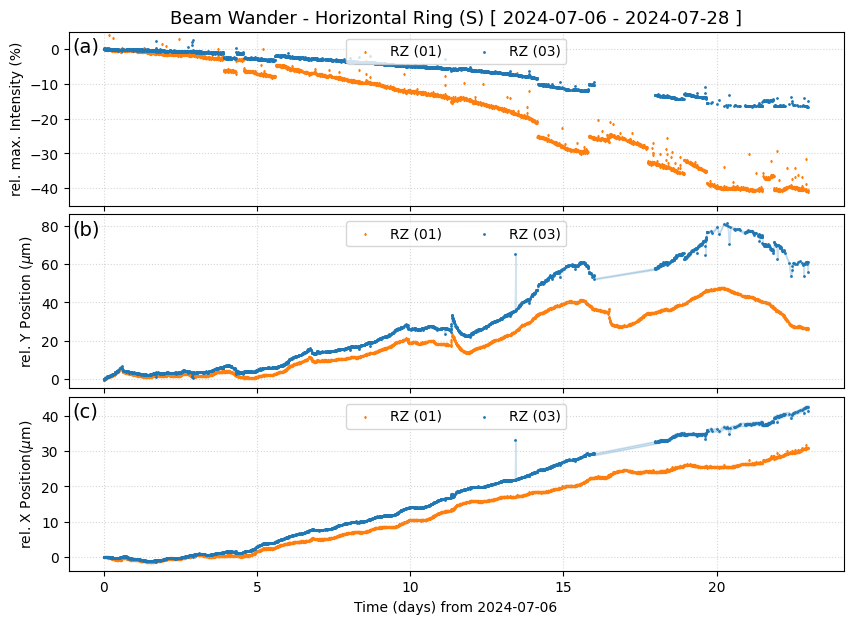

In [22]:
def __makeplot_beam_wander(dfs):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from functions.reduce import __reduce

    time_scaling = 1/86400

    sigma_scaling = 1/2

    Ncol, Nrow = 1, 3

    font = 12

    fig = plt.figure(figsize=(10, 7))

    gs = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :])

    plt.subplots_adjust(hspace=0.05)

    for i, df0 in enumerate(dfs):
        if i == 0:

            ax1.scatter(df0.time_sec*time_scaling, __reduce(df0.amp/255*100, 20),
                        c="tab:orange", s=1, zorder=2, label="RZ (01)", marker="d")
            ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c="tab:orange", s=1, zorder=1, label="RZ (01)", marker="d")
            ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c="tab:orange", s=1, zorder=1, label="RZ (01)", marker="d")
            ax2.fill_between(df0.time_sec*time_scaling,
                             df0.y_um_rel-abs(df0.y_um_var)*sigma_scaling,
                             df0.y_um_rel+abs(df0.y_um_var)*sigma_scaling,
                             color="tab:orange", alpha=0.2, interpolate=False
                            )
            ax3.fill_between(df0.time_sec*time_scaling,
                             df0.x_um_rel-abs(df0.x_um_var)*sigma_scaling,
                             df0.x_um_rel+abs(df0.x_um_var)*sigma_scaling,
                             color="tab:orange", alpha=0.2, interpolate=False
                            )
        elif i == 1:

            ax1.scatter(df0.time_sec*time_scaling, __reduce(df0.amp/255*100, 20),
                        c="tab:blue", s=1, zorder=2, label="RZ (03)")
            ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c="tab:blue", s=1, zorder=2, label="RZ (03)")
            ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c="tab:blue", s=1, zorder=2, label="RZ (03)")
            ax2.fill_between(df0.time_sec*time_scaling,
                             df0.y_um_rel-abs(df0.y_um_var)*sigma_scaling,
                             df0.y_um_rel+abs(df0.y_um_var)*sigma_scaling,
                             color="tab:blue", alpha=0.2, interpolate=False
                            )
            ax3.fill_between(df0.time_sec*time_scaling,
                             df0.x_um_rel-abs(df0.x_um_var)*sigma_scaling,
                             df0.x_um_rel+abs(df0.x_um_var)*sigma_scaling,
                             color="tab:blue", alpha=0.2, interpolate=False
                             )
    ax1.set_ylabel("rel. max. Intensity (%)")
    ax2.set_ylabel("rel. Y Position ($\mu$m)")
    ax3.set_ylabel("rel. X Position($\mu$m)")
    # ax3.set_xlabel(f"Time (days) from {str(df0.time_utc.iloc[0])[:10]} {str(df0.time_utc.iloc[0])[11:19]} UTC")
    ax3.set_xlabel(f"Time (days) from {str(df0.time_utc.iloc[0])[:10]}")


    for _k, (ax, ll) in enumerate(zip([ax1, ax2, ax3], ['(a)', '(b)', '(c)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)
        ax.legend(loc=9, ncol=2)

    # ax1.set_ylim(-3, 2)
    ax1.set_ylim(-45, 5)
    # ax2.set_ylim(-5, 45)
    # ax3.set_ylim(-5, 25)

    # add title
    ax1.set_title(f"Beam Wander - Horizontal Ring (S) [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot_beam_wander([df01, df03])

fig.savefig(config['path_to_figures']+f"BeamWander_RZ_01_and_03_{config['date1']}_{config['date2']}_2.png",
            format="png", dpi=150, bbox_inches='tight')
